# Packages & Data Loading

## Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from dateutil.parser import parse
import re
import webbrowser
from ydata_profiling import ProfileReport
from ydata_profiling.config import Settings

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

import gdown

In [2]:
# Show graphs
%matplotlib inline

## Data Loading

In [3]:
# Google Drive file 
file_id = '1yvAWHeK86zTHyQvJi0paT3-EP19JYk0L'
# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file 
output_path = 'unemployment_dataset.csv'
gdown.download(download_url, output_path, quiet=False)

# Load the CSV 
unemployment_df = pd.read_csv(output_path)

# Display the DataFrame 
print(unemployment_df.head())

Downloading...
From: https://drive.google.com/uc?export=download&id=1yvAWHeK86zTHyQvJi0paT3-EP19JYk0L
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 860 - Adv. Data Analytics Project\06 - Initial Results, Code (10%)\~ Exploratory Analysis\unemployment_dataset.csv
100%|██████████| 62.9M/62.9M [00:05<00:00, 11.7MB/s]


  REF_DATE                        GEO        DGUID  \
0  1997-01  Newfoundland and Labrador  2016A000210   
1  1997-02  Newfoundland and Labrador  2016A000210   
2  1997-03  Newfoundland and Labrador  2016A000210   
3  1997-04  Newfoundland and Labrador  2016A000210   
4  1997-05  Newfoundland and Labrador  2016A000210   

  Labour force characteristics  \
0            Unemployment rate   
1            Unemployment rate   
2            Unemployment rate   
3            Unemployment rate   
4            Unemployment rate   

  North American Industry Classification System (NAICS)    Sex  \
0             Agriculture [111-112, 1100, 1151-1152]     Males   
1             Agriculture [111-112, 1100, 1151-1152]     Males   
2             Agriculture [111-112, 1100, 1151-1152]     Males   
3             Agriculture [111-112, 1100, 1151-1152]     Males   
4             Agriculture [111-112, 1100, 1151-1152]     Males   

        Age group         UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID     VECTOR

In [4]:
# Google Drive file ID from the new URL
file_id = '1bASVHvEJkKQCwamT3NpqVNxIe4tde5ke'
# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file to a local path
output_path = 'wage_dataset.csv'
gdown.download(download_url, output_path, quiet=False)

# Load the CSV into a DataFrame
wage_df = pd.read_csv(output_path)

# Display the DataFrame to verify
print(wage_df.head())

Downloading...
From: https://drive.google.com/uc?export=download&id=1bASVHvEJkKQCwamT3NpqVNxIe4tde5ke
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 860 - Adv. Data Analytics Project\06 - Initial Results, Code (10%)\~ Exploratory Analysis\wage_dataset.csv
100%|██████████| 62.0M/62.0M [00:05<00:00, 12.3MB/s]


  REF_DATE                        GEO        DGUID                    Wages  \
0   Jan-97  Newfoundland and Labrador  2016A000210  Median hourly wage rate   
1   Feb-97  Newfoundland and Labrador  2016A000210  Median hourly wage rate   
2   Mar-97  Newfoundland and Labrador  2016A000210  Median hourly wage rate   
3   Apr-97  Newfoundland and Labrador  2016A000210  Median hourly wage rate   
4   May-97  Newfoundland and Labrador  2016A000210  Median hourly wage rate   

          Type of work North American Industry Classification System (NAICS)  \
0  Full-time employees             Agriculture [111-112, 1100, 1151-1152]      
1  Full-time employees             Agriculture [111-112, 1100, 1151-1152]      
2  Full-time employees             Agriculture [111-112, 1100, 1151-1152]      
3  Full-time employees             Agriculture [111-112, 1100, 1151-1152]      
4  Full-time employees             Agriculture [111-112, 1100, 1151-1152]      

     Sex       Age group              UOM  U

In [5]:
# Check and drop unnecessary columns
columns_to_drop = ['DGUID', 'Type of work', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']
columns_to_drop_unemployment = [col for col in columns_to_drop if col in unemployment_df.columns]
columns_to_drop_wage = [col for col in columns_to_drop if col in wage_df.columns]

data_employment = unemployment_df.drop(columns=columns_to_drop_unemployment)
data_wage = wage_df.drop(columns=columns_to_drop_wage)

# Ensure column names are normalized (lowercase and replace spaces with underscores)
data_employment.columns = [col.lower().replace(' ', '_') for col in data_employment.columns]
data_wage.columns = [col.lower().replace(' ', '_') for col in data_wage.columns]

# Rename the column from 'north_american_industry_classification_system_(naics)' to 'industry'
data_employment.rename(columns={'north_american_industry_classification_system_(naics)': 'industry'}, inplace=True)
data_wage.rename(columns={'north_american_industry_classification_system_(naics)': 'industry'}, inplace=True)

# Rename the column from 'labour_force_characteristics' to 'labour_force'
data_employment.rename(columns={'labour_force_characteristics': 'labour_force'}, inplace=True)
data_wage.rename(columns={'labour_force_characteristics': 'labour_force'}, inplace=True)

# Data Cleaning

## Date standardization

### Wage - date standardization

In [6]:
# Function to fix inconsistent date formats
def fix_date_format(date_string):
    if pd.isna(date_string):
        return pd.NaT

    # Strip any leading/trailing spaces
    date_string = date_string.strip()

    # Check if date is in 'YY-MMM' or 'MMM-YY' format and convert
    # Handle 'YY-MMM' (e.g., '21-Mar') and 'MMM-YY' (e.g., 'Mar-21')
    if re.match(r'^\d{2}-[A-Za-z]{3}$', date_string):
        year, month = date_string.split('-')
        date_string = f'{month}-{year}'
    elif re.match(r'^[A-Za-z]{3}-\d{2}$', date_string):
        month, year = date_string.split('-')
        # Correctly handle century assumption based on year value
        if int(year) >= 97:  # If year is 97, 98, 99 -> assume 1997, 1998, 1999
            date_string = f'{month}-19{year}'
        else:  # If year is 00-23 -> assume 2000s
            date_string = f'{month}-20{year}'

    # Try parsing the date using dateutil
    try:
        parsed_date = parse(date_string, fuzzy=False)
        # Set the day explicitly to the 1st of the month if not already provided
        parsed_date = parsed_date.replace(day=1)
        return parsed_date
    except ValueError:
        return pd.NaT

# Apply the function to the 'ref_date' column to standardize the format
data_wage['ref_date'] = data_wage['ref_date'].apply(fix_date_format)

# Convert to the final 'yyyy-mm-dd' format
data_wage['ref_date'] = data_wage['ref_date'].dt.strftime('%Y-%m-%d')

# Print the updated DataFrame to verify the results
print("\nUpdated DataFrame with 'ref_date' in 'yyyy-mm-dd' format:")
print(data_wage.head())



Updated DataFrame with 'ref_date' in 'yyyy-mm-dd' format:
     ref_date                        geo                    wages  \
0  1997-01-01  Newfoundland and Labrador  Median hourly wage rate   
1  1997-02-01  Newfoundland and Labrador  Median hourly wage rate   
2  1997-03-01  Newfoundland and Labrador  Median hourly wage rate   
3  1997-04-01  Newfoundland and Labrador  Median hourly wage rate   
4  1997-05-01  Newfoundland and Labrador  Median hourly wage rate   

                                 industry    sex       age_group  value  
0  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
1  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
2  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
3  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
4  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  


In [7]:
# Count the number of missing values in the 'ref_date' column
missing_values_count = data_wage['ref_date'].isna().sum()

# Print the count of missing values
print(f"Number of missing values in 'ref_date': {missing_values_count}")

# Filter and list all rows where 'ref_date' is missing
missing_rows = data_wage[data_wage['ref_date'].isna()]

# Print the rows with missing 'ref_date' values
print("\nRows with missing 'ref_date':")
print(missing_rows)

print(data_wage.head())

Number of missing values in 'ref_date': 0

Rows with missing 'ref_date':
Empty DataFrame
Columns: [ref_date, geo, wages, industry, sex, age_group, value]
Index: []
     ref_date                        geo                    wages  \
0  1997-01-01  Newfoundland and Labrador  Median hourly wage rate   
1  1997-02-01  Newfoundland and Labrador  Median hourly wage rate   
2  1997-03-01  Newfoundland and Labrador  Median hourly wage rate   
3  1997-04-01  Newfoundland and Labrador  Median hourly wage rate   
4  1997-05-01  Newfoundland and Labrador  Median hourly wage rate   

                                 industry    sex       age_group  value  
0  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
1  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
2  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
3  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
4  Agriculture [111-112, 1100, 1151-1152]  Males  1

In [8]:
# Function to verify if all values in date format 'yyyy-mm-dd'
def is_valid_yyyy_mm_dd_format(date_string):
    try:
        # Try to parse using the expected format
        datetime_obj = pd.to_datetime(date_string, format='%Y-%m-%d', errors='coerce')
        return not pd.isna(datetime_obj)  
    except:
        return False

# Rechecking each value in the 'ref_date' column to ensure they are properly formatted
invalid_date_rows = []

for idx, date in enumerate(data_wage['ref_date']):
    if pd.isna(date) or is_valid_yyyy_mm_dd_format(date):
        continue
    else:
        # If the date does not match 'yyyy-mm-dd', add the row to invalid list
        invalid_date_rows.append(data_wage.iloc[idx])

# Print the results of the validation
if len(invalid_date_rows) == 0:
    print("All dates in 'ref_date' are properly formatted in 'yyyy-mm-dd'.")
else:
    print("\nRows with incorrectly formatted 'ref_date':")
    for row in invalid_date_rows:
        print(row)


All dates in 'ref_date' are properly formatted in 'yyyy-mm-dd'.


### Unemployment - date standardization

In [9]:
# Function to fix inconsistent date formats
def fix_date_format_emp(date_string_emp):
    if pd.isna(date_string_emp):
        return pd.NaT

    # Strip any spaces
    date_string_emp = date_string_emp.strip()

    # Check if date is in 'YY-MMM' or 'MMM-YY' format and convert
    # Handle 'YY-MMM' (e.g., '21-Mar') and 'MMM-YY' (e.g., 'Mar-21')
    if re.match(r'^\d{2}-[A-Za-z]{3}$', date_string_emp):
        year, month = date_string_emp.split('-')
        date_string_emp = f'{month}-{year}'
    elif re.match(r'^[A-Za-z]{3}-\d{2}$', date_string_emp):
        month, year = date_string_emp.split('-')
        # Correctly handle century assumption based on year value
        if int(year) >= 97:  # If year is >= 97 -> assume 1997, 1998, 1999
            date_string_emp = f'{month}-19{year}'
        else:  # If year is 00-23 -> assume 2000s
            date_string_emp = f'{month}-20{year}'

    # Try parsing the date using dateutil
    try:
        parsed_date_emp = parse(date_string_emp, fuzzy=False)
        # Set the day explicitly to the 1st of the month 
        parsed_date_emp = parsed_date_emp.replace(day=1)
        return parsed_date_emp
    except ValueError:
        return pd.NaT

# Apply the function to the 'ref_date' column to standardize the format
data_employment['ref_date'] = data_employment['ref_date'].apply(fix_date_format_emp)

# Convert to the final 'yyyy-mm-dd' format
data_employment['ref_date'] = data_employment['ref_date'].dt.strftime('%Y-%m-%d')

# Print the updated DataFrame to verify the results
print("\nUpdated DataFrame with 'ref_date' in 'yyyy-mm-dd' format:")
print(data_employment.head())



Updated DataFrame with 'ref_date' in 'yyyy-mm-dd' format:
     ref_date                        geo       labour_force  \
0  1997-01-01  Newfoundland and Labrador  Unemployment rate   
1  1997-02-01  Newfoundland and Labrador  Unemployment rate   
2  1997-03-01  Newfoundland and Labrador  Unemployment rate   
3  1997-04-01  Newfoundland and Labrador  Unemployment rate   
4  1997-05-01  Newfoundland and Labrador  Unemployment rate   

                                 industry    sex       age_group  value  
0  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
1  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
2  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
3  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
4  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  


In [10]:
# Count the number of missing values in the 'ref_date' column
missing_values_count_emp = data_employment['ref_date'].isna().sum()

# Print the count of missing values
print(f"Number of missing values in 'ref_date': {missing_values_count_emp}")

# Filter and list all rows where 'ref_date' is missing
missing_rows_emp = data_employment[data_employment['ref_date'].isna()]

# Print the rows with missing 'ref_date' values
print("\nRows with missing 'ref_date':")
print(missing_rows_emp)

print(data_employment.head())

Number of missing values in 'ref_date': 0

Rows with missing 'ref_date':
Empty DataFrame
Columns: [ref_date, geo, labour_force, industry, sex, age_group, value]
Index: []
     ref_date                        geo       labour_force  \
0  1997-01-01  Newfoundland and Labrador  Unemployment rate   
1  1997-02-01  Newfoundland and Labrador  Unemployment rate   
2  1997-03-01  Newfoundland and Labrador  Unemployment rate   
3  1997-04-01  Newfoundland and Labrador  Unemployment rate   
4  1997-05-01  Newfoundland and Labrador  Unemployment rate   

                                 industry    sex       age_group  value  
0  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
1  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
2  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
3  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  
4  Agriculture [111-112, 1100, 1151-1152]  Males  15 to 24 years    NaN  


In [11]:
# Function to verify if all values in date format 'yyyy-mm-dd'
def is_valid_yyyy_mm_dd_format_emp(date_string_emp):
    try:
        # Try to parse using the expected format
        datetime_obj_emp = pd.to_datetime(date_string_emp, format='%Y-%m-%d', errors='coerce')
        return not pd.isna(datetime_obj_emp)  
    except:
        return False

# Rechecking each value in the 'ref_date' column to ensure they are properly formatted
invalid_date_rows_emp = []

for idx, date in enumerate(data_employment['ref_date']):
    if pd.isna(date) or is_valid_yyyy_mm_dd_format_emp(date):
        continue
    else:
        # If the date does not match 'yyyy-mm-dd', add the row to invalid list
        invalid_date_rows_emp.append(data_employment.iloc[idx])

# Print the results of the validation
if len(invalid_date_rows_emp) == 0:
    print("All dates in 'ref_date' are properly formatted in 'yyyy-mm-dd'.")
else:
    print("\nRows with incorrectly formatted 'ref_date':")
    for row in invalid_date_rows_emp:
        print(row)


All dates in 'ref_date' are properly formatted in 'yyyy-mm-dd'.


## Merge the datasets

In [12]:
print(data_employment.columns)
print(data_wage.columns)

Index(['ref_date', 'geo', 'labour_force', 'industry', 'sex', 'age_group',
       'value'],
      dtype='object')
Index(['ref_date', 'geo', 'wages', 'industry', 'sex', 'age_group', 'value'], dtype='object')


In [13]:
# Merge datasets on common columns
merged_df = pd.merge(data_employment, data_wage, 
                     on=["ref_date", "geo", "industry", "sex", "age_group"],
                     how="outer",
                     suffixes=('_unemployment', '_wage'))

In [14]:
# Convert 'ref_date' to datetime format
merged_df['ref_date'] = pd.to_datetime(merged_df['ref_date'], errors='coerce')

# Extract year and month from 'ref_date' for correlation analysis
merged_df['year'] = merged_df['ref_date'].dt.year
merged_df['month'] = merged_df['ref_date'].dt.month

# convert 'ref_date' to a numeric timestamp
merged_df['ref_date_numeric'] = merged_df['ref_date'].apply(lambda x: x.timestamp() if pd.notnull(x) else None)
merged_df['ref_date_numeric'] = pd.to_numeric(merged_df['ref_date_numeric'], errors='coerce').astype('float64')

# Check the data types to confirm 'ref_date' is in datetime format
print(merged_df.dtypes)


ref_date              datetime64[ns]
geo                           object
labour_force                  object
industry                      object
sex                           object
age_group                     object
value_unemployment           float64
wages                         object
value_wage                   float64
year                           int32
month                          int32
ref_date_numeric             float64
dtype: object


In [15]:
# Configure the settings with specified correlation options
config = Settings()
config.correlations = {
    "pearson": {"calculate": True},
    "spearman": {"calculate": True},
    "kendall": {"calculate": True},
    "phi_k": {"calculate": True},
    "auto": {"calculate": True},
}

# Generate the profile report
profile_inter = ProfileReport(
    merged_df,
    title="EDA Report - Original Data",
    config=config
)

# Save the report to an HTML file
report_filename = "eda_report.html"
profile_inter.to_file(report_filename)

# Open the report in web browser
webbrowser.open(report_filename)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nesha\anaconda3\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
c:\Users\nesha\anaconda3\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

True

**OPTIONAL**

Save Data to a CSV file
merged_df.to_csv('merged_df.csv', index=True)

print("Merged data saved to 'merged_df.csv'.") 

In [16]:
print(merged_df.head())

    ref_date      geo       labour_force  \
0 1997-01-01  Alberta  Unemployment rate   
1 1997-01-01  Alberta  Unemployment rate   
2 1997-01-01  Alberta  Unemployment rate   
3 1997-01-01  Alberta  Unemployment rate   
4 1997-01-01  Alberta  Unemployment rate   

                               industry      sex          age_group  \
0  Accommodation and food services [72]  Females     15 to 24 years   
1  Accommodation and food services [72]  Females     25 to 54 years   
2  Accommodation and food services [72]  Females  55 years and over   
3  Accommodation and food services [72]    Males     15 to 24 years   
4  Accommodation and food services [72]    Males     25 to 54 years   

   value_unemployment                    wages  value_wage  year  month  \
0                 9.7  Median hourly wage rate        7.00  1997      1   
1                 6.3  Median hourly wage rate        8.00  1997      1   
2                 NaN  Median hourly wage rate         NaN  1997      1   
3       

In [17]:
# Dataset Overview
print("\nNumeric variables:\n\n",merged_df.describe())

print("Number of obs and features:", merged_df.shape,"\n\n")  # number of observations and features

print("Data types:", merged_df.dtypes,"\n\n") # data types

print("Number of duplicated values:", merged_df[merged_df.duplicated()],"\n\n") # check duplicated values

print("Number of missing values per feature:", merged_df.isna().sum(),"\n\n") # missing values per feature

print("Number of missing values:", merged_df.isna().sum().sum(),"\n\n") # number of missing cells
print("Percentage of missing values:", round(merged_df.isna().sum().sum() / merged_df.size * 100, 1),"\n") # percentage of missing cells


Numeric variables:

                             ref_date  value_unemployment     value_wage  \
count                         349920        78604.000000  245179.000000   
mean   2010-06-16 13:46:40.000000256           12.230362      19.954671   
min              1997-01-01 00:00:00            0.500000       3.130000   
25%              2003-09-23 12:00:00            4.700000      13.460000   
50%              2010-06-16 00:00:00            8.300000      18.270000   
75%              2017-03-08 18:00:00           15.300000      25.000000   
max              2023-12-01 00:00:00          100.000000     115.380000   
std                              NaN           12.039903       8.777156   

                year          month  ref_date_numeric  
count  349920.000000  349920.000000      3.499200e+05  
mean     2010.000000       6.500000      1.276696e+09  
min      1997.000000       1.000000      8.520768e+08  
25%      2003.000000       3.750000      1.064318e+09  
50%      2010.000000  

## Missing values 

### Inspect Missing Values

In [18]:
# Filter rows based on the conditions:
# 1. There is data in 'labour force' and a missing value in 'value_unemployment'.
# 2. There is data in 'wages' and a missing value in 'type_of_work' AND/OR 'value_wage'.
data_missing = merged_df[
    ((merged_df['labour_force'].notna()) & (merged_df['value_unemployment'].isna())) |
    ((merged_df['wages'].notna()) & (merged_df[['value_wage']].isna().any(axis=1)))
]

print(data_missing.head())

# Total number of rows in the original dataset
total_rows = merged_df.shape[0]

# Count the number of rows with missing data
missing_rows = data_missing.shape[0]
print(missing_rows)

# Calculate the percentage of rows with missing data
missing_percentage = (missing_rows / total_rows) * 100

# Output the result
print(f"Percentage of rows with missing data: {missing_percentage:.2f}%")


    ref_date      geo       labour_force  \
2 1997-01-01  Alberta  Unemployment rate   
5 1997-01-01  Alberta  Unemployment rate   
6 1997-01-01  Alberta  Unemployment rate   
7 1997-01-01  Alberta  Unemployment rate   
8 1997-01-01  Alberta  Unemployment rate   

                                 industry      sex          age_group  \
2    Accommodation and food services [72]  Females  55 years and over   
5    Accommodation and food services [72]    Males  55 years and over   
6  Agriculture [111-112, 1100, 1151-1152]  Females     15 to 24 years   
7  Agriculture [111-112, 1100, 1151-1152]  Females     25 to 54 years   
8  Agriculture [111-112, 1100, 1151-1152]  Females  55 years and over   

   value_unemployment                    wages  value_wage  year  month  \
2                 NaN  Median hourly wage rate         NaN  1997      1   
5                 NaN  Median hourly wage rate         NaN  1997      1   
6                 NaN  Median hourly wage rate         NaN  1997      1

In [19]:
# Summarize Missing Values in the DataFrame
missing_summary = data_missing.isna().sum()
print("\nSummary of Missing Values in 'data_missing':")
print(missing_summary,"\n\n")

# Group and Aggregate to Identify Trends
# Grouping by 'geo', 'industry', and 'sex' for trends in missing values
grouped_geo = data_missing.groupby('geo').size().reset_index(name='count')
grouped_industry = data_missing.groupby('industry').size().reset_index(name='count')
grouped_sex = data_missing.groupby('sex').size().reset_index(name='count')

# Print the trends
print("\nNumber of Missing Values Grouped by 'geo':")
print(grouped_geo)

print("\n\nNumber of Missing Values Grouped by 'industry':")
print(grouped_industry)

print("\n\nNumber of Missing Values Grouped by 'sex':")
print(grouped_sex)


Summary of Missing Values in 'data_missing':
ref_date                   0
geo                        0
labour_force            6704
industry                   0
sex                        0
age_group                  0
value_unemployment    239140
wages                  31305
value_wage             97166
year                       0
month                      0
ref_date_numeric           0
dtype: int64 



Number of Missing Values Grouped by 'geo':
                         geo  count
0                    Alberta  25199
1           British Columbia  23664
2                   Manitoba  26024
3              New Brunswick  25625
4  Newfoundland and Labrador  27281
5                Nova Scotia  24373
6                    Ontario  15325
7       Prince Edward Island  28184
8                     Quebec  18285
9               Saskatchewan  27163


Number of Missing Values Grouped by 'industry':
                                             industry  count
0                Accommodation and food

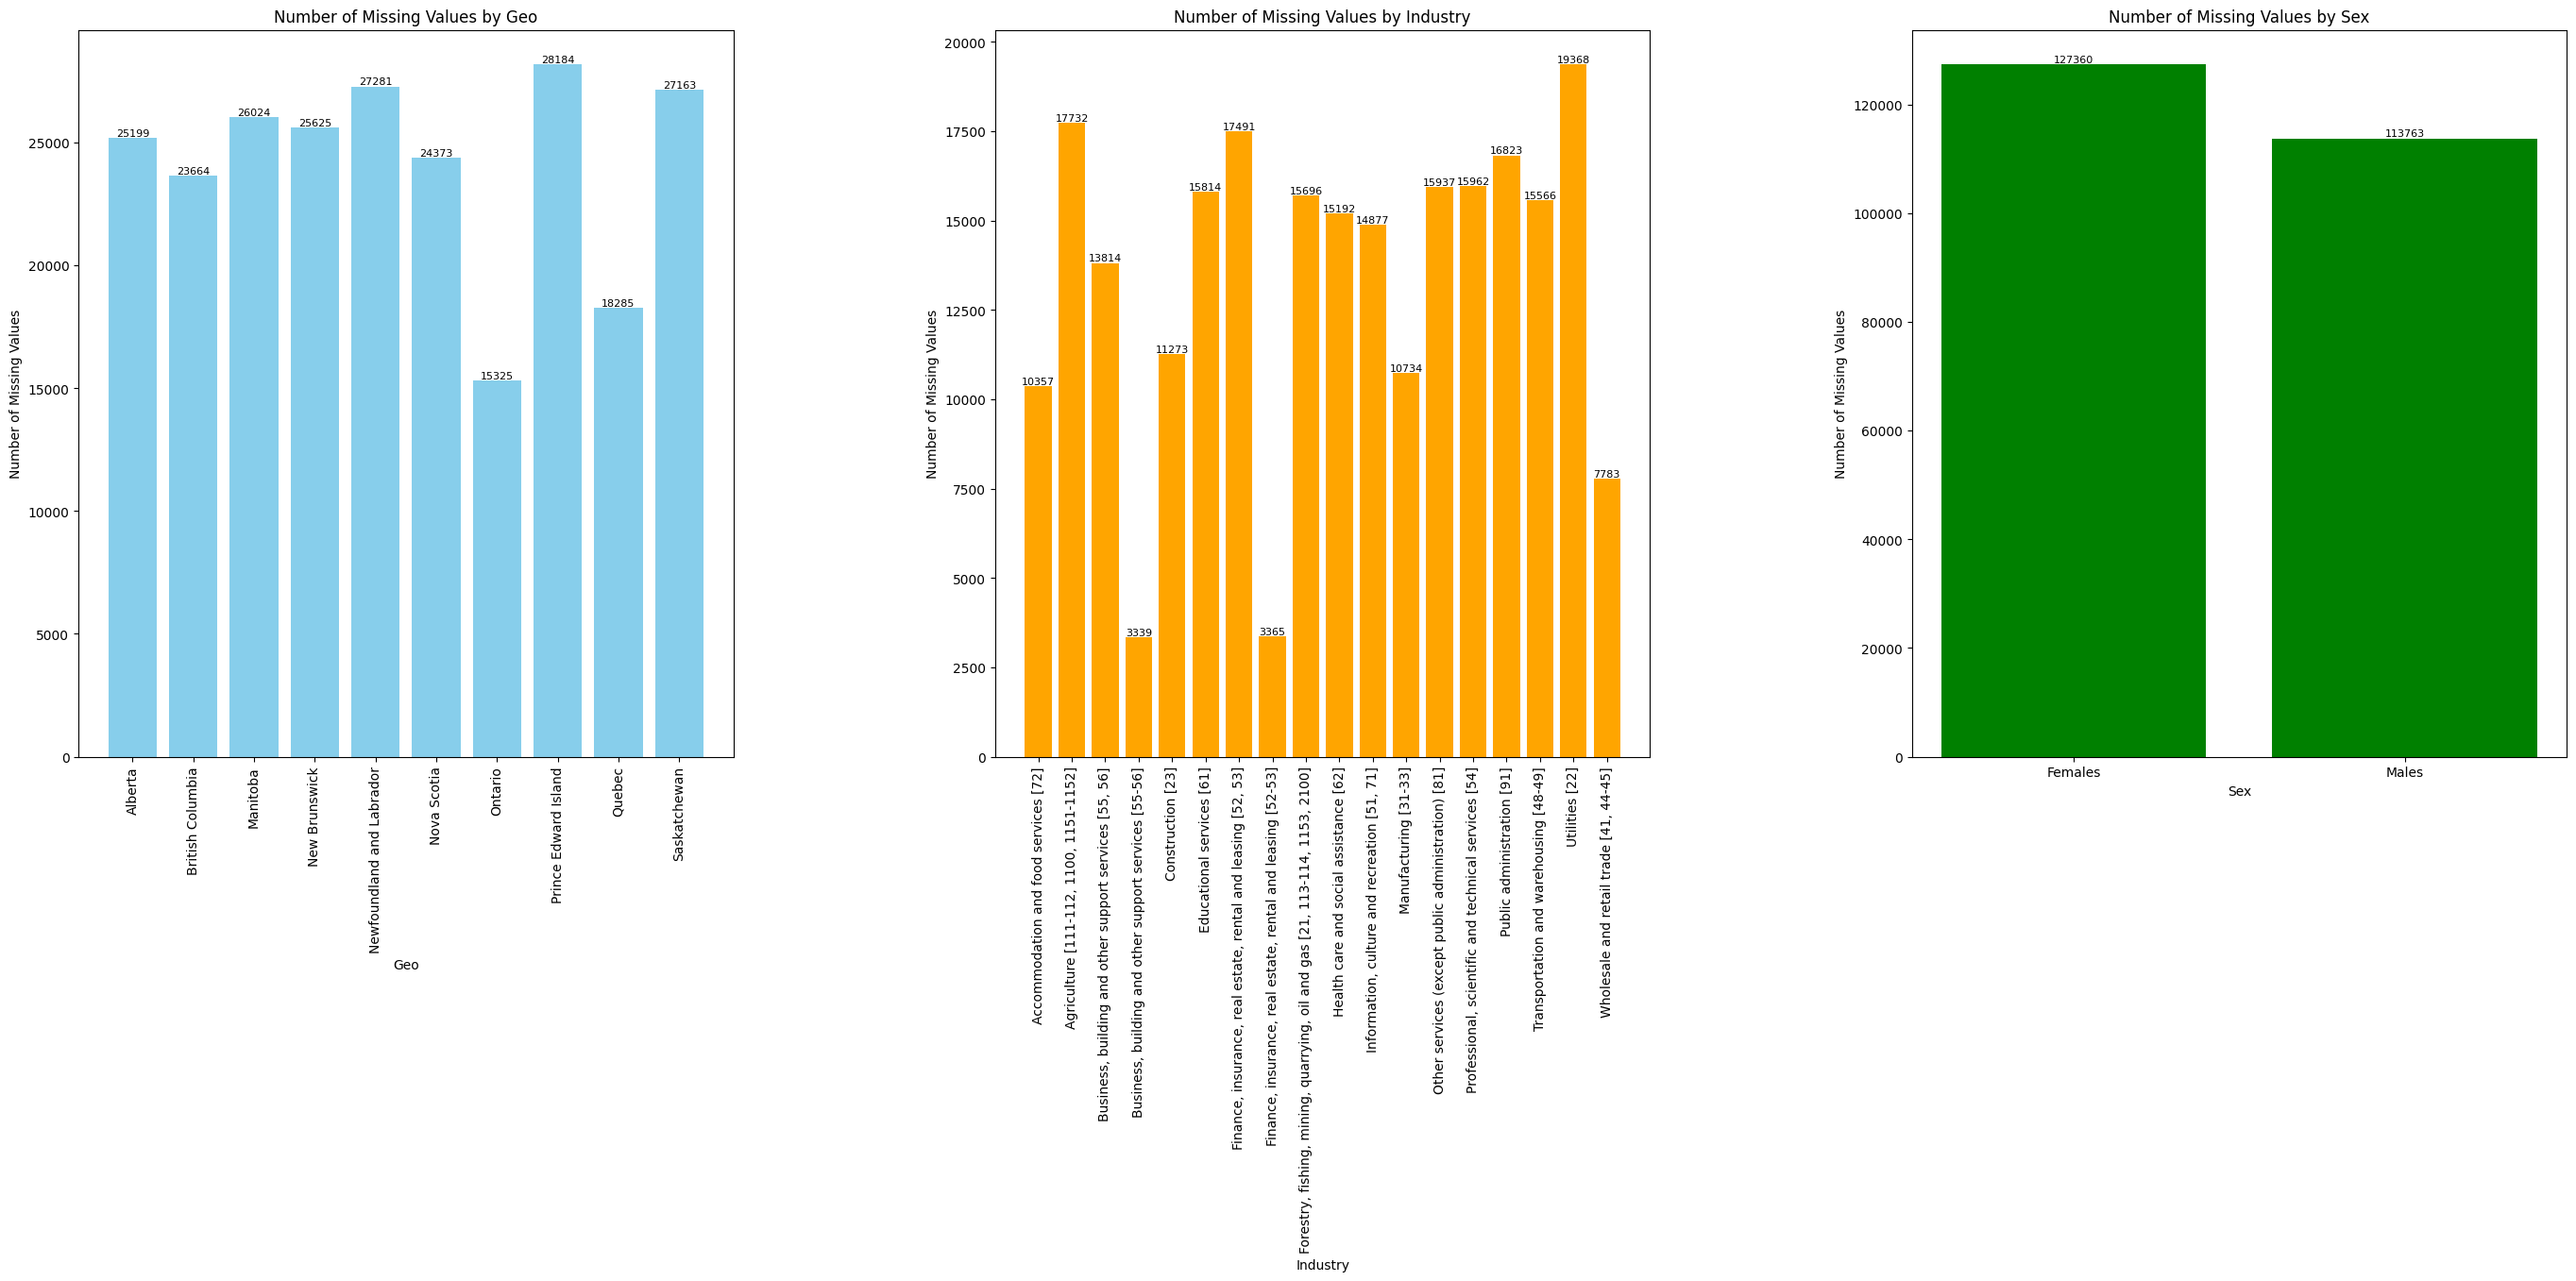

In [ ]:
# Creating a figure with 1 row and 3 columns with increased figure size
fig, axes = plt.subplots(1, 3, figsize=(34, 10))

# Plotting the number of missing values by 'geo'
axes[0].bar(grouped_geo['geo'], grouped_geo['count'], color='skyblue')
axes[0].set_xlabel('Geo')
axes[0].set_ylabel('Number of Missing Values')
axes[0].set_title('Number of Missing Values by Geo')
axes[0].tick_params(axis='x', rotation=90)

# Adding labels on bars for 'geo'
for i, value in enumerate(grouped_geo['count']):
    axes[0].text(i, value, str(value), ha='center', va='bottom', fontsize=8)

# Plotting the number of missing values by 'industry' with narrower bars for spacing
bar_positions = np.arange(len(grouped_industry['industry']))
bar_width = 0.3

# Plotting the number of missing values by 'industry'
axes[1].bar(grouped_industry['industry'], grouped_industry['count'], color='orange')
axes[1].set_xlabel('Industry')
axes[1].set_ylabel('Number of Missing Values')
axes[1].set_title('Number of Missing Values by Industry')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(bar_positions)
axes[1].set_xticklabels(grouped_industry['industry'], rotation=90)

# Adding labels on bars for 'industry'
for i, value in enumerate(grouped_industry['count']):
    axes[1].text(i, value, str(value), ha='center', va='bottom', fontsize=8)

# Plotting the number of missing values by 'sex'
axes[2].bar(grouped_sex['sex'], grouped_sex['count'], color='green')
axes[2].set_xlabel('Sex')
axes[2].set_ylabel('Number of Missing Values')
axes[2].set_title('Number of Missing Values by Sex')

# Adding labels on bars for 'sex'
for i, value in enumerate(grouped_sex['count']):
    axes[2].text(i, value, str(value), ha='center', va='bottom', fontsize=8)

# Adjust spacing between plots to avoid label overlap
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


In [21]:
# Percentage of value counts for all columns
for column in data_missing.columns:
    total_count = len(data_missing[column])
    print(f"\nPercentage counts for column '{column}':")
    
    # Calculate the value counts and convert them 
    percentage_counts = (data_missing[column].value_counts() / total_count) * 100
    
    print(percentage_counts)
    print("\n" + "-"*50 + "\n") 



Percentage counts for column 'ref_date':
ref_date
2022-06-01    0.342564
2022-09-01    0.341734
2022-10-01    0.338416
2022-11-01    0.335513
2022-07-01    0.332196
                ...   
2020-08-01    0.256301
2020-07-01    0.252568
2020-06-01    0.248006
2020-04-01    0.240956
2020-05-01    0.231832
Name: count, Length: 324, dtype: float64

--------------------------------------------------


Percentage counts for column 'geo':
geo
Prince Edward Island         11.688640
Newfoundland and Labrador    11.314143
Saskatchewan                 11.265205
Manitoba                     10.792832
New Brunswick                10.627356
Alberta                      10.450683
Nova Scotia                  10.108119
British Columbia              9.814078
Quebec                        7.583267
Ontario                       6.355677
Name: count, dtype: float64

--------------------------------------------------


Percentage counts for column 'labour_force':
labour_force
Unemployment rate    97.219676


### Linear Interpolation

In [22]:
# Make a copy of the data
interpolated_data = merged_df.copy()

#Unemployment Rate
print('Unemployment Rate')
# Apply linear interpolation
interpolated_data['value_unemployment'] = interpolated_data['value_unemployment'].interpolate(method='linear')
# Verify that missing values have been handled
print("\nMissing Unemployment Values in Original Data:\n", merged_df['value_unemployment'].isnull().sum())
print("\nMissing Unemployment Values After Interpolation in New DataFrame:\n", interpolated_data['value_unemployment'].isnull().sum())


#Wage Rate
print('\n\n\nWage Rate')
# Apply linear interpolation
interpolated_data['value_wage'] = interpolated_data['value_wage'].interpolate(method='linear')
# Verify that missing values have been handled
print("\nMissing Wage Values in Original Data:\n", merged_df['value_wage'].isnull().sum())
print("\nMissing Wage Values After Interpolation in New DataFrame:\n", interpolated_data['value_wage'].isnull().sum())

Unemployment Rate

Missing Unemployment Values in Original Data:
 271316

Missing Unemployment Values After Interpolation in New DataFrame:
 0



Wage Rate

Missing Wage Values in Original Data:
 104741

Missing Wage Values After Interpolation in New DataFrame:
 0


In [23]:
# Configure the settings with specified correlation options
config = Settings()
config.correlations = {
    "pearson": {"calculate": True},
    "spearman": {"calculate": True},
    "kendall": {"calculate": True},
    "phi_k": {"calculate": True},
    "auto": {"calculate": True},
}

# Generate the profile report
profile_inter = ProfileReport(
    interpolated_data,
    title="EDA Report - Interpolated Data",
    config=config
)

# Save the report to an HTML file
report_filename = "eda_report_interpolated.html"
profile_inter.to_file(report_filename)

# Open the report in the default web browser
webbrowser.open(report_filename)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nesha\anaconda3\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
c:\Users\nesha\anaconda3\Lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

True

# Initial Analysis

## Correlation

In [24]:
# Create copy for further analysis
unindexed_df = interpolated_data.copy()

In [25]:
# Correlation analysis between unemployment and wage
correlation_ref_date = unindexed_df.groupby(['ref_date']).agg({
    'value_unemployment': 'mean',
    'value_wage': 'mean'
})

correlation_year = unindexed_df.groupby(['year']).agg({
    'value_unemployment': 'mean',
    'value_wage': 'mean'
})

correlation_month = unindexed_df.groupby(['month']).agg({
    'value_unemployment': 'mean',
    'value_wage': 'mean'
})

correlation_ref_date_numeric = unindexed_df.groupby(['ref_date_numeric']).agg({
    'value_unemployment': 'mean',
    'value_wage': 'mean'
})



correlation_ref_date = correlation_ref_date.corr()
print("\nCorrelation Matrix (ref_date):\n", correlation_ref_date )

correlation_year = correlation_year.corr()
print("\n\nCorrelation Matrix (year):\n", correlation_year)

correlation_month = correlation_month.corr()
print("\n\nCorrelation Matrix (month):\n", correlation_month)

correlation_ref_date_numeric = correlation_ref_date_numeric.corr()
print("\n\nCorrelation Matrix (ref_date_numeric):\n", correlation_ref_date_numeric)



Correlation Matrix (ref_date):
                     value_unemployment  value_wage
value_unemployment            1.000000    0.062725
value_wage                    0.062725    1.000000


Correlation Matrix (year):
                     value_unemployment  value_wage
value_unemployment            1.000000    0.058457
value_wage                    0.058457    1.000000


Correlation Matrix (month):
                     value_unemployment  value_wage
value_unemployment            1.000000    0.499429
value_wage                    0.499429    1.000000


Correlation Matrix (ref_date_numeric):
                     value_unemployment  value_wage
value_unemployment            1.000000    0.062725
value_wage                    0.062725    1.000000


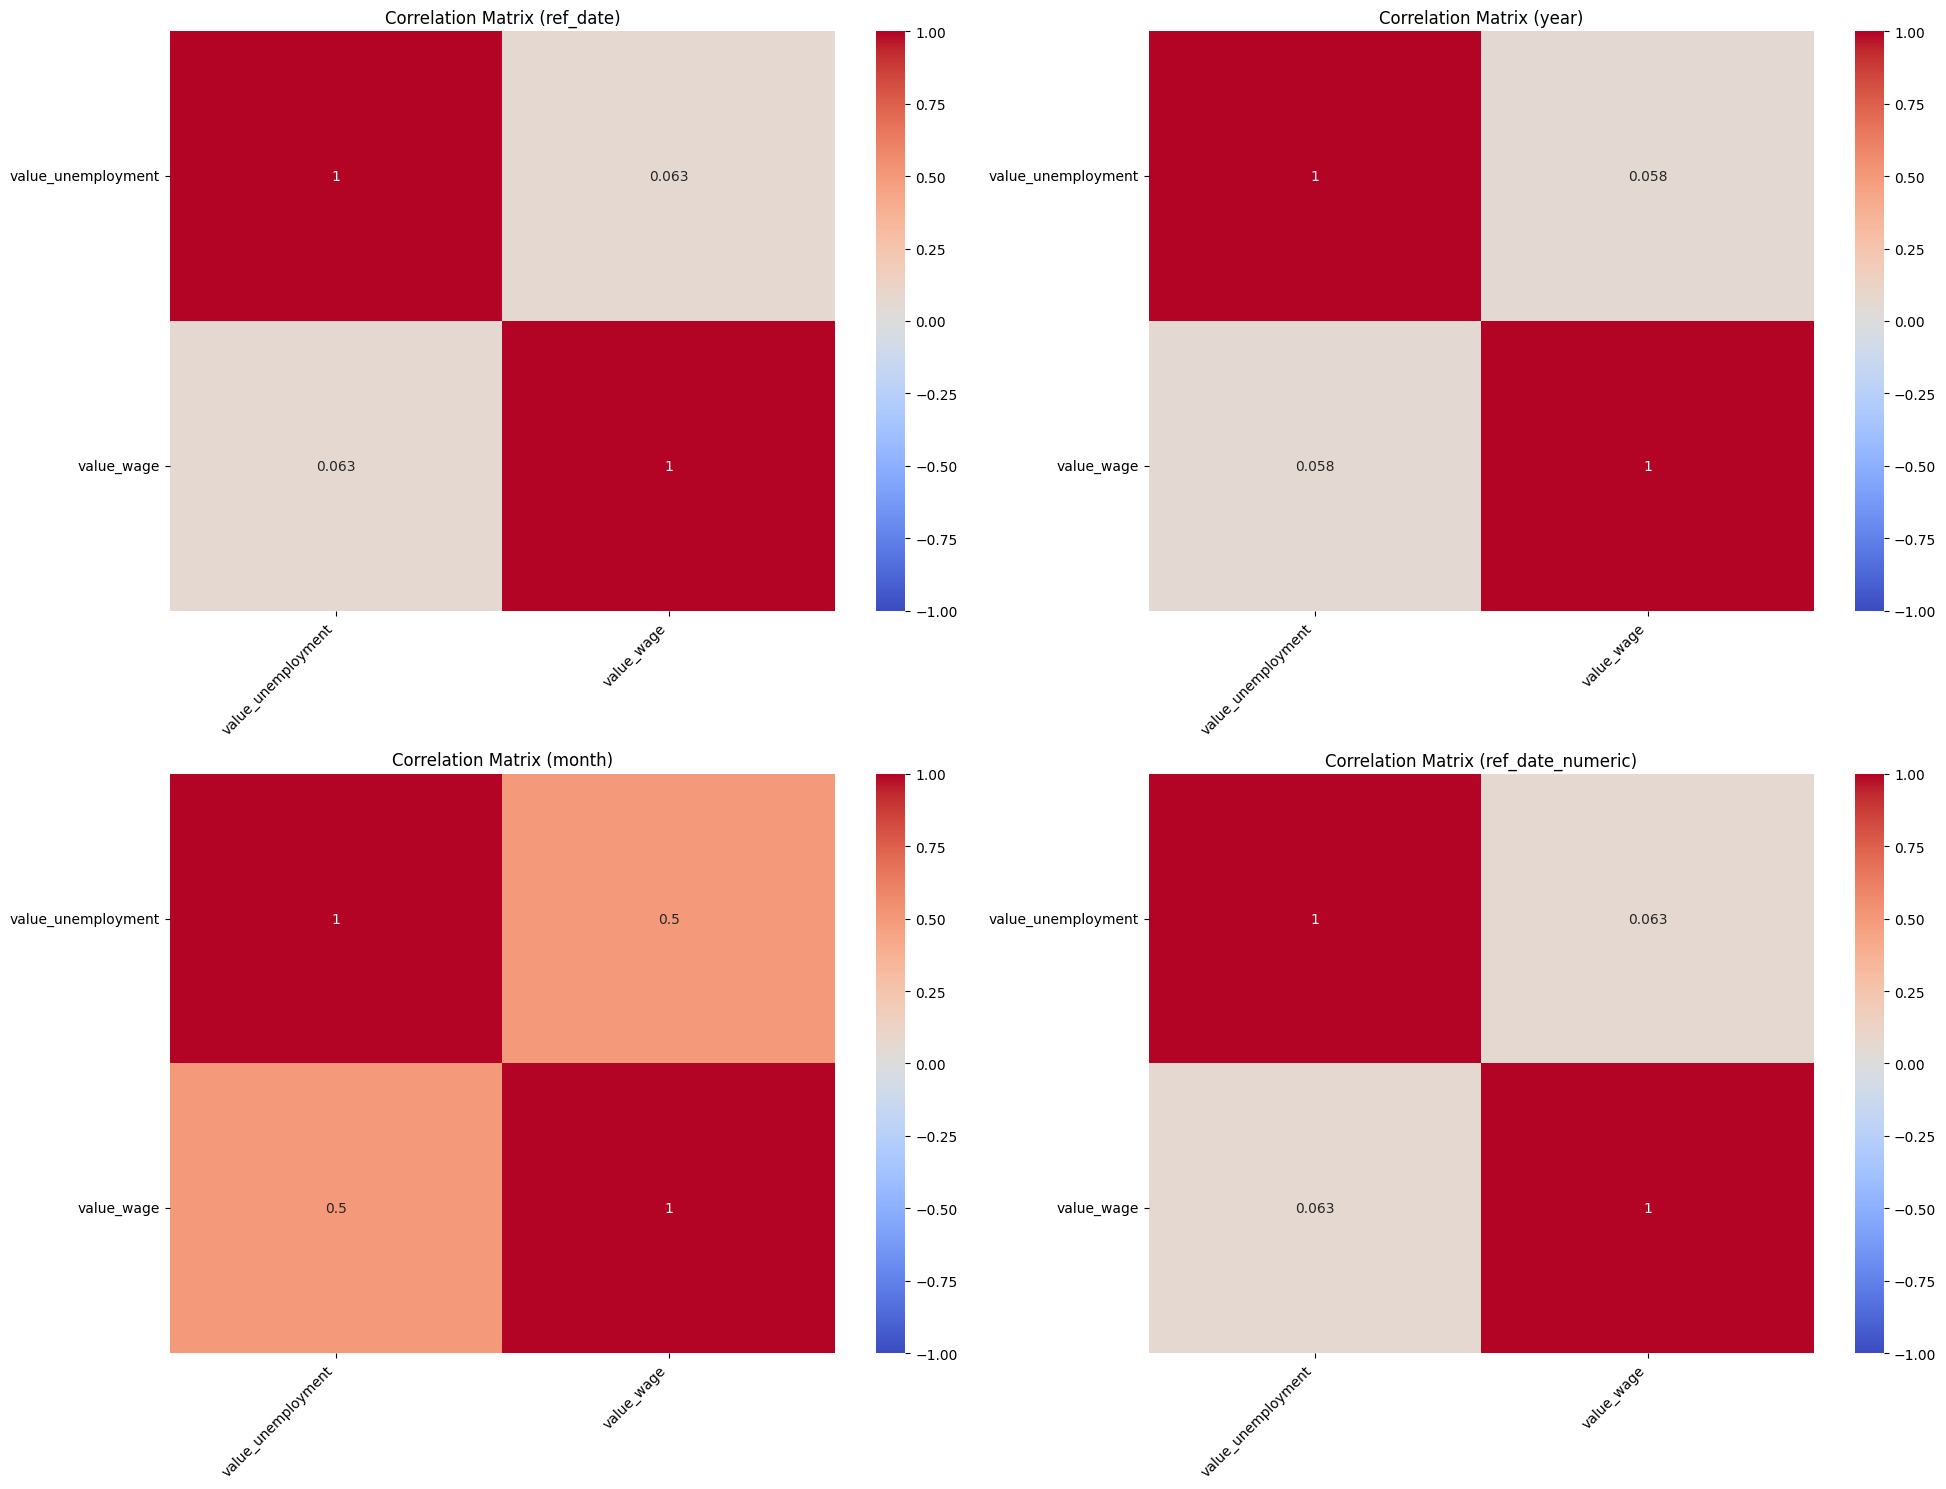

In [26]:
# Set the min and max value for the color scale across all correlation heatmaps
vmin = -1  # Minimum possible value for correlation
vmax = 1   # Maximum possible value for correlation

# Create a 2x2 subplot for the correlation matrices
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot heatmap for correlation matrix by 'ref_date'
sns.heatmap(correlation_ref_date, annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax, ax=axes[0, 0])
axes[0, 0].set_title('Correlation Matrix (ref_date)')
axes[0, 0].set_xticklabels(correlation_ref_date.columns, rotation=45, ha='right')
axes[0, 0].set_yticklabels(correlation_ref_date.columns, rotation=0)

# Plot heatmap for correlation matrix by 'year'
sns.heatmap(correlation_year, annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax, ax=axes[0, 1])
axes[0, 1].set_title('Correlation Matrix (year)')
axes[0, 1].set_xticklabels(correlation_year.columns, rotation=45, ha='right')
axes[0, 1].set_yticklabels(correlation_year.columns, rotation=0)

# Plot heatmap for correlation matrix by 'month'
sns.heatmap(correlation_month, annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax, ax=axes[1, 0])
axes[1, 0].set_title('Correlation Matrix (month)')
axes[1, 0].set_xticklabels(correlation_month.columns, rotation=45, ha='right')
axes[1, 0].set_yticklabels(correlation_month.columns, rotation=0)

# Plot heatmap for correlation matrix by 'ref_date_numeric'
sns.heatmap(correlation_ref_date_numeric, annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax, ax=axes[1, 1])
axes[1, 1].set_title('Correlation Matrix (ref_date_numeric)')
axes[1, 1].set_xticklabels(correlation_ref_date_numeric.columns, rotation=45, ha='right')
axes[1, 1].set_yticklabels(correlation_ref_date_numeric.columns, rotation=0)

# Adjust the layout 
plt.tight_layout()
plt.show()

## Normality Assumptions


Median Wage Rate

Kolmogorov-Smirnov Test: Statistic = 0.0841, p-value = 0.0000

Anderson-Darling Test: Statistic = 4988.9074
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]

D'Agostino and Pearson's Test: Statistic = 53987.9474, p-value = 0.0000


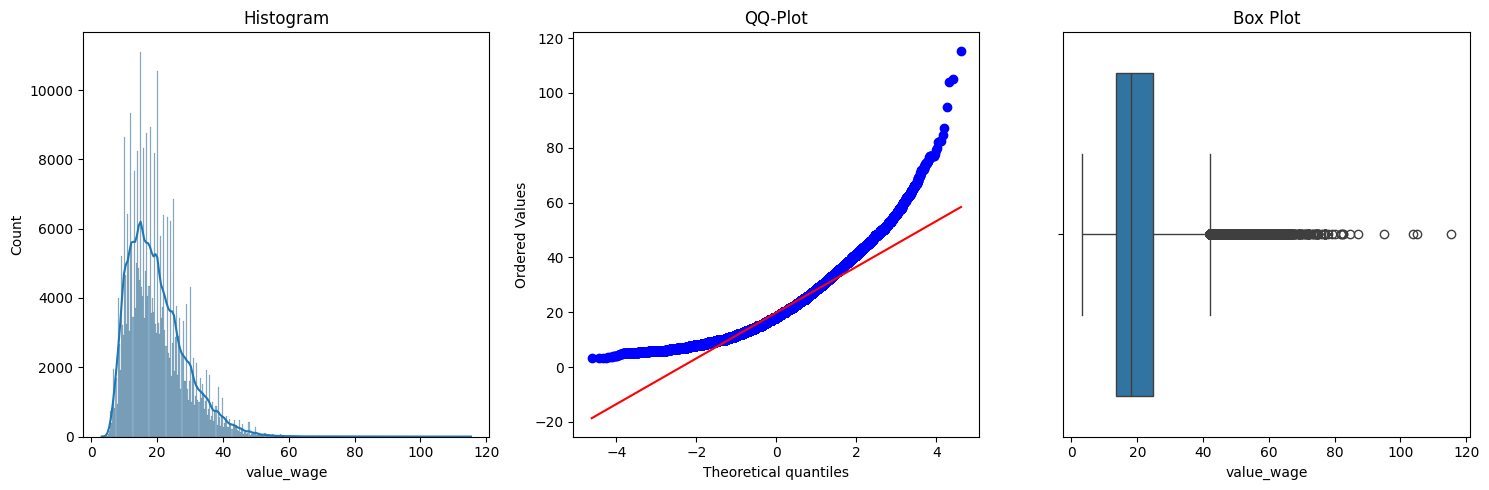

In [27]:
# Wage Data

# Prepare the data
print("\nMedian Wage Rate")
column_to_test = interpolated_data['value_wage']

# Conduct normality tests
# Kolmogorov-Smirnov Test
ks_stat, ks_p = stats.kstest(column_to_test, 'norm', args=(column_to_test.mean(), column_to_test.std()))
print("\nKolmogorov-Smirnov Test: Statistic = {:.4f}, p-value = {:.4f}".format(ks_stat, ks_p))

# Anderson-Darling Test
anderson_result = stats.anderson(column_to_test, dist='norm')
print("\nAnderson-Darling Test: Statistic = {:.4f}".format(anderson_result.statistic))
print("Critical values:", anderson_result.critical_values)
print("Significance levels:", anderson_result.significance_level)

# D'Agostino and Pearson's Test
dagostino_stat, dagostino_p = stats.normaltest(column_to_test)
print("\nD'Agostino and Pearson's Test: Statistic = {:.4f}, p-value = {:.4f}".format(dagostino_stat, dagostino_p))

# Visualizations
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 3, 1)
sns.histplot(column_to_test, kde=True)
plt.title("Histogram")

# QQ-Plot
plt.subplot(1, 3, 2)
stats.probplot(column_to_test, dist="norm", plot=plt)
plt.title("QQ-Plot")

# Box Plot
plt.subplot(1, 3, 3)
sns.boxplot(x=column_to_test)
plt.title("Box Plot")

plt.tight_layout()
plt.show()


Unemployment Rate

Kolmogorov-Smirnov Test: Statistic = 0.1583, p-value = 0.0000

Anderson-Darling Test: Statistic = 20445.1554
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]

D'Agostino and Pearson's Test: Statistic = 171068.1753, p-value = 0.0000


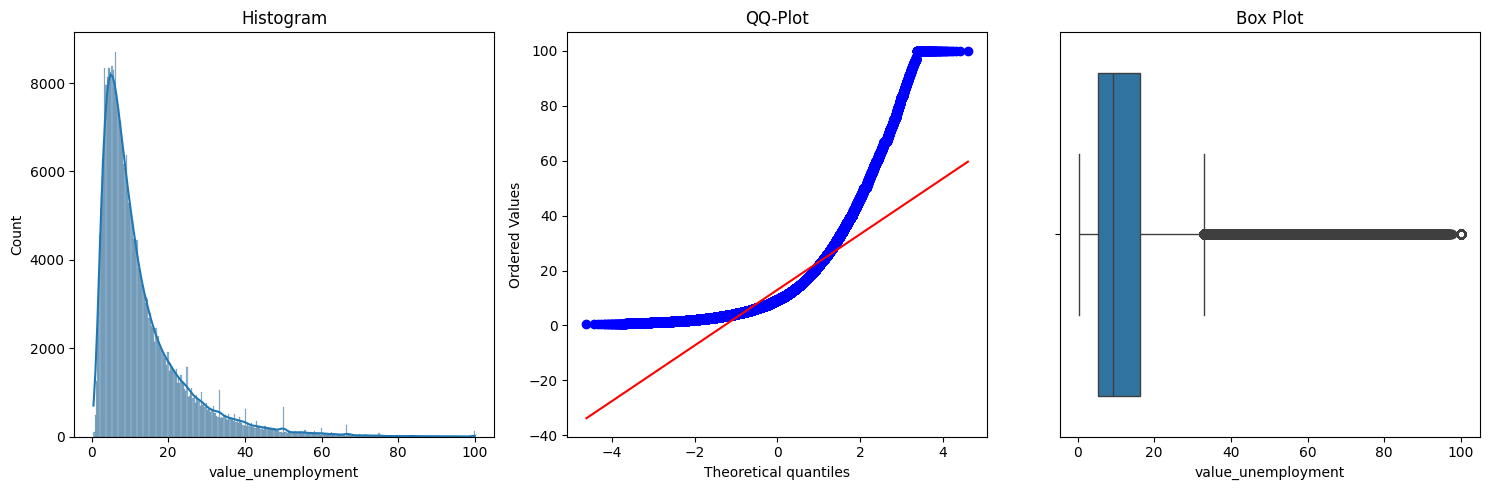

In [28]:
# Unemployment Data

# Prepare the data
print("\nUnemployment Rate")
column_to_test_emp = interpolated_data['value_unemployment']

# Conduct normality tests

# Kolmogorov-Smirnov Test
ks_stat_emp, ks_p_emp = stats.kstest(column_to_test_emp, 'norm', args=(column_to_test_emp.mean(), column_to_test_emp.std()))
print("\nKolmogorov-Smirnov Test: Statistic = {:.4f}, p-value = {:.4f}".format(ks_stat_emp, ks_p_emp))

# Anderson-Darling Test
anderson_result_emp = stats.anderson(column_to_test_emp, dist='norm')
print("\nAnderson-Darling Test: Statistic = {:.4f}".format(anderson_result_emp.statistic))
print("Critical values:", anderson_result_emp.critical_values)
print("Significance levels:", anderson_result_emp.significance_level)

# D'Agostino and Pearson's Test
dagostino_stat_emp, dagostino_p_emp = stats.normaltest(column_to_test_emp)
print("\nD'Agostino and Pearson's Test: Statistic = {:.4f}, p-value = {:.4f}".format(dagostino_stat_emp, dagostino_p_emp))

# Visualizations
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 3, 1)
sns.histplot(column_to_test_emp, kde=True)
plt.title("Histogram")

# QQ-Plot
plt.subplot(1, 3, 2)
stats.probplot(column_to_test_emp, dist="norm", plot=plt)
plt.title("QQ-Plot")

# Box Plot
plt.subplot(1, 3, 3)
sns.boxplot(x=column_to_test_emp)
plt.title("Box Plot")

plt.tight_layout()
plt.show()

## Visualizations

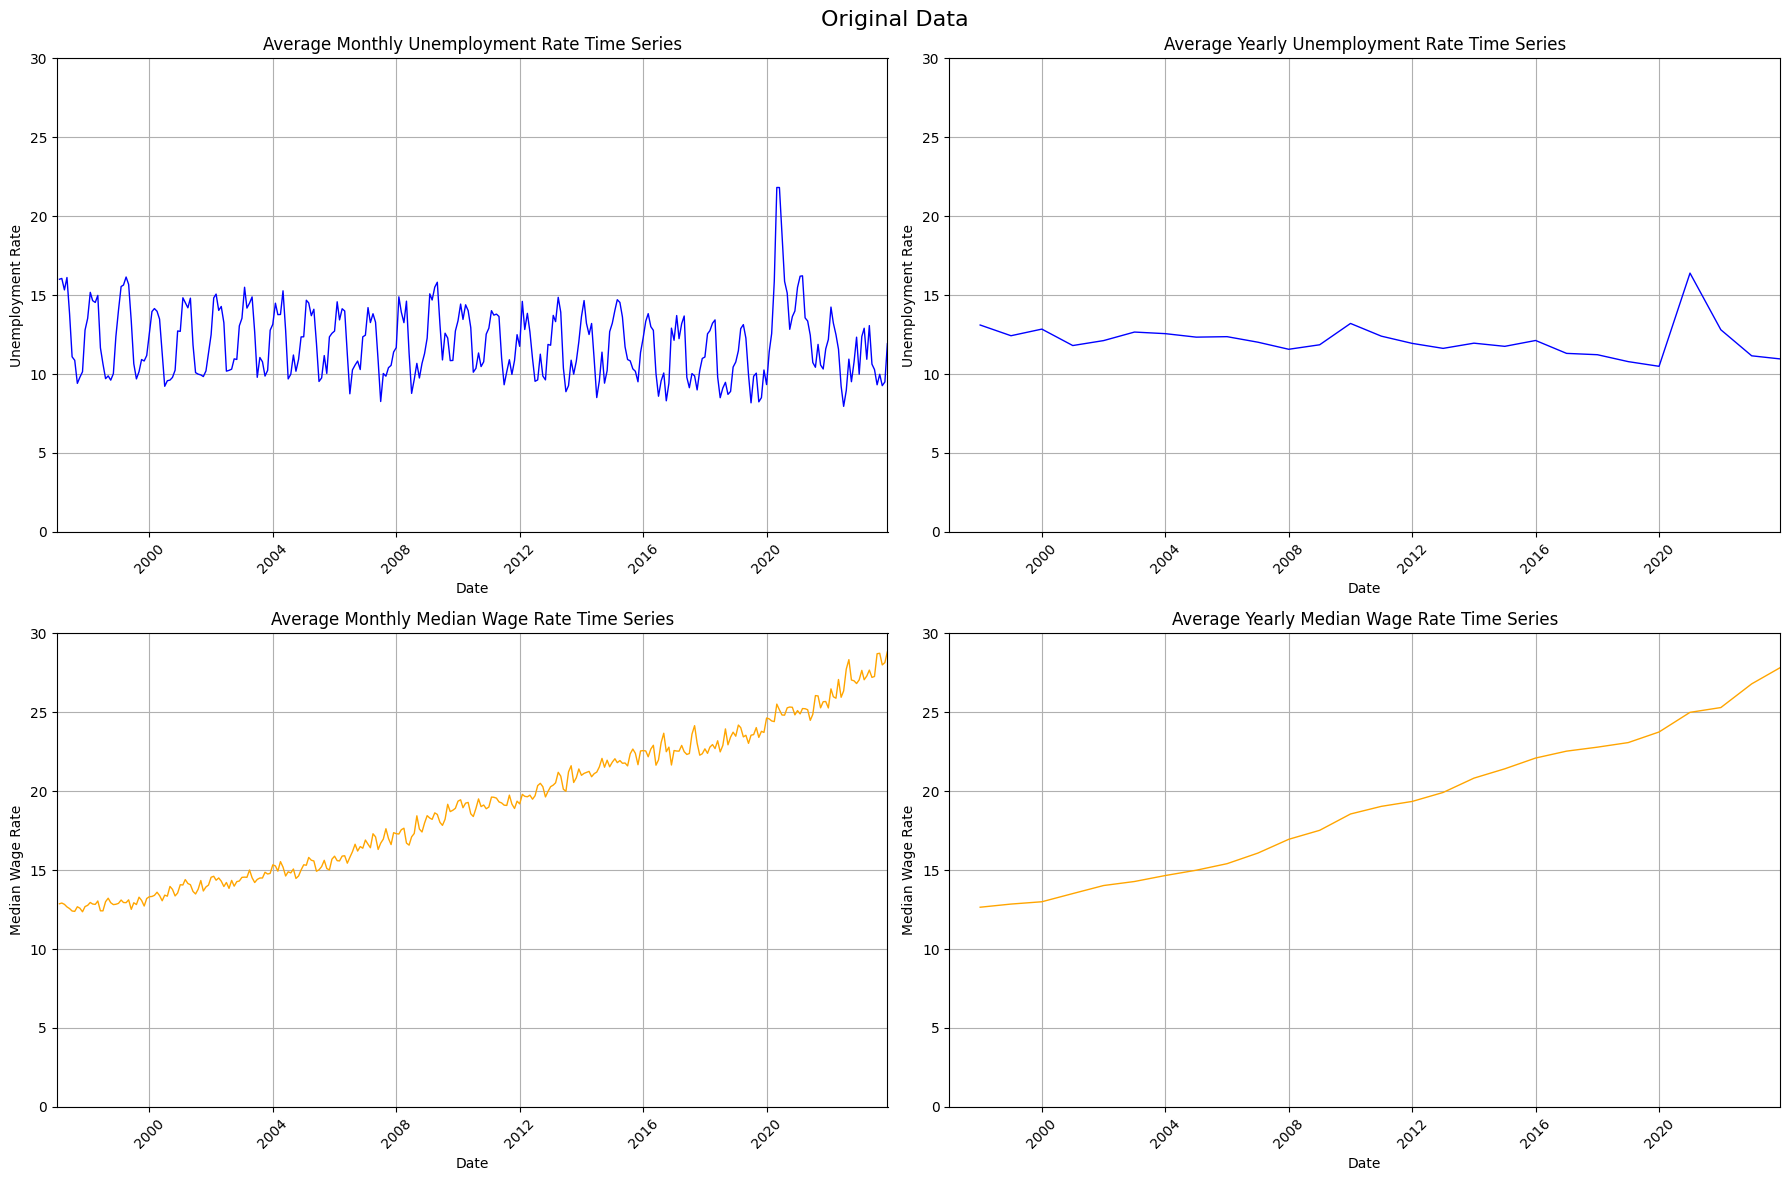

In [29]:
# Copy dataframe
plot_df = merged_df.copy()

# Ensure 'ref_date' is in datetime format
plot_df['ref_date'] = pd.to_datetime(plot_df['ref_date'], errors='coerce')

# Set 'ref_date' as the index to enable resampling
plot_df.set_index('ref_date', inplace=True)

# Drop any rows where 'ref_date' could not be converted to datetime (in case some were NaT)
plot_df.dropna(subset=['value_unemployment'], inplace=True)



# Create figure 
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  

# Set the overall title
fig.suptitle('Original Data', fontsize=16)

# Define common x-axis range based on the min and max index values
x_min, x_max = plot_df.index.min(), plot_df.index.max()

# Set common y-axis limit
y_max = 30

# Resample the unemployment rate to get the monthly average and plot
df_monthly_emp = plot_df['value_unemployment'].resample('ME').mean()
axes[0, 0].plot(df_monthly_emp.index, df_monthly_emp.values, color='blue', linewidth=1)
axes[0, 0].set_title('Average Monthly Unemployment Rate Time Series')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Unemployment Rate')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True)
axes[0, 0].set_xlim([x_min, x_max])
axes[0, 0].set_ylim([0, y_max])

# Resample the unemployment rate to get the yearly average and plot
df_yearly_emp = plot_df['value_unemployment'].resample('YE').mean()
axes[0, 1].plot(df_yearly_emp.index, df_yearly_emp.values, color='blue', linewidth=1)
axes[0, 1].set_title('Average Yearly Unemployment Rate Time Series')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Unemployment Rate')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True)
axes[0, 1].set_xlim([x_min, x_max])
axes[0, 1].set_ylim([0, y_max])

# Resample the wage rate to get the monthly average and plot
df_monthly_wage = plot_df['value_wage'].resample('ME').mean()
axes[1, 0].plot(df_monthly_wage.index, df_monthly_wage.values, color='orange', linewidth=1)
axes[1, 0].set_title('Average Monthly Median Wage Rate Time Series')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Median Wage Rate')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True)
axes[1, 0].set_xlim([x_min, x_max])
axes[1, 0].set_ylim([0, y_max])

# Resample the wage rate to get the yearly average and plot
df_yearly_wage = plot_df['value_wage'].resample('YE').mean()
axes[1, 1].plot(df_yearly_wage.index, df_yearly_wage.values, color='orange', linewidth=1)
axes[1, 1].set_title('Average Yearly Median Wage Rate Time Series')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Median Wage Rate')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True)
axes[1, 1].set_xlim([x_min, x_max])
axes[1, 1].set_ylim([0, y_max])

# Adjust layout to ensure subplots don't overlap
plt.tight_layout()
plt.show()

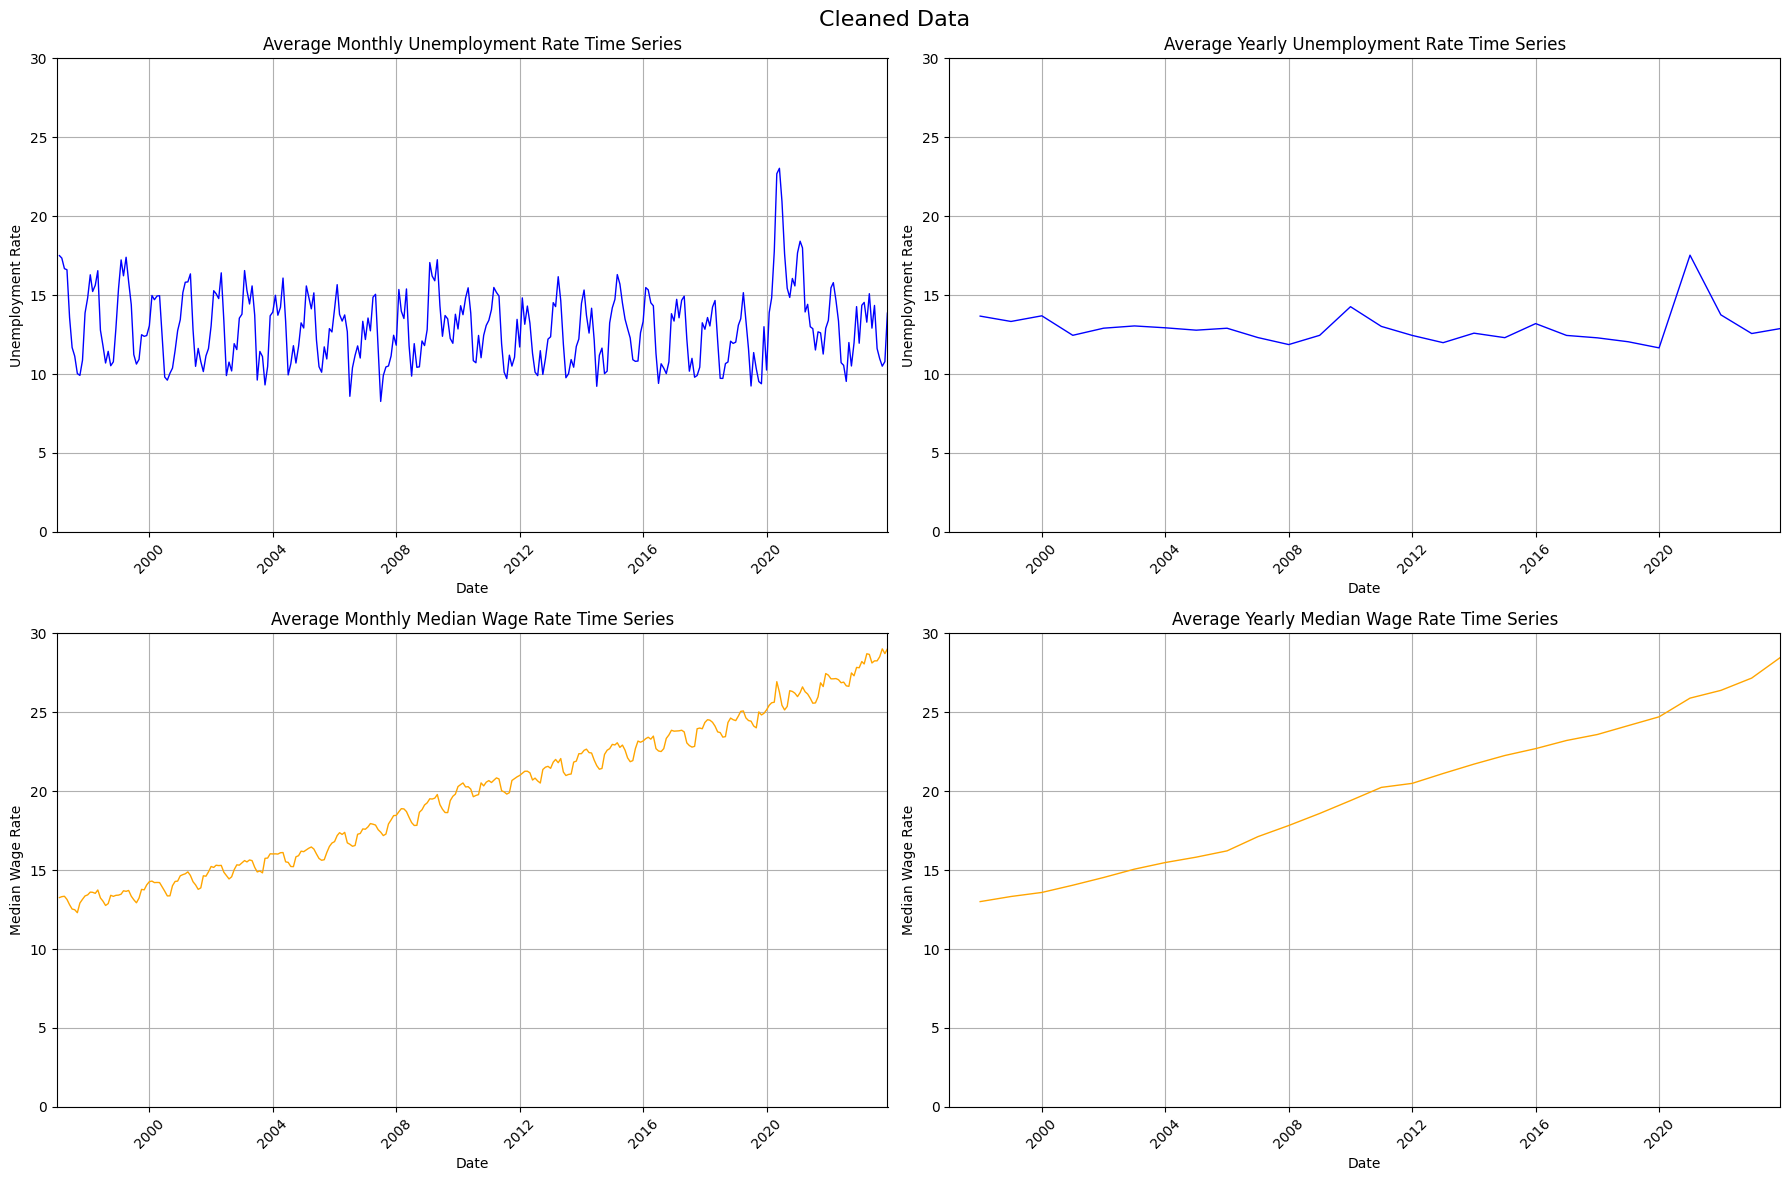

In [30]:
# Copy dataframe
plot_interpolated = interpolated_data.copy()

# Ensure 'ref_date' is in datetime format
plot_interpolated['ref_date'] = pd.to_datetime(plot_interpolated['ref_date'], errors='coerce')

# Set 'ref_date' as the index to enable resampling
plot_interpolated.set_index('ref_date', inplace=True)

# Drop any rows where 'ref_date' could not be converted to datetime (in case some were NaT)
plot_interpolated.dropna(subset=['value_unemployment'], inplace=True)

# Create figure 
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  

# Set the overall title
fig.suptitle('Cleaned Data', fontsize=16)

# Define common x-axis range based on the min and max index values
x_min, x_max = plot_interpolated.index.min(), plot_interpolated.index.max()

# Set common y-axis limit
y_max = 30

# Resample the unemployment rate to get the monthly average and plot
df_monthly_emp = plot_interpolated['value_unemployment'].resample('ME').mean()
axes[0, 0].plot(df_monthly_emp.index, df_monthly_emp.values, color='blue', linewidth=1)
axes[0, 0].set_title('Average Monthly Unemployment Rate Time Series')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Unemployment Rate')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True)
axes[0, 0].set_xlim([x_min, x_max])
axes[0, 0].set_ylim([0, y_max])

# Resample the unemployment rate to get the yearly average and plot
df_yearly_emp = plot_interpolated['value_unemployment'].resample('YE').mean()
axes[0, 1].plot(df_yearly_emp.index, df_yearly_emp.values, color='blue', linewidth=1)
axes[0, 1].set_title('Average Yearly Unemployment Rate Time Series')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Unemployment Rate')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True)
axes[0, 1].set_xlim([x_min, x_max])
axes[0, 1].set_ylim([0, y_max])

# Resample the wage rate to get the monthly average and plot
df_monthly_wage = plot_interpolated['value_wage'].resample('ME').mean()
axes[1, 0].plot(df_monthly_wage.index, df_monthly_wage.values, color='orange', linewidth=1)
axes[1, 0].set_title('Average Monthly Median Wage Rate Time Series')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Median Wage Rate')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True)
axes[1, 0].set_xlim([x_min, x_max])
axes[1, 0].set_ylim([0, y_max])

# Resample the wage rate to get the yearly average and plot
df_yearly_wage = plot_interpolated['value_wage'].resample('YE').mean()
axes[1, 1].plot(df_yearly_wage.index, df_yearly_wage.values, color='orange', linewidth=1)
axes[1, 1].set_title('Average Yearly Median Wage Rate Time Series')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Median Wage Rate')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True)
axes[1, 1].set_xlim([x_min, x_max])
axes[1, 1].set_ylim([0, y_max])

# Adjust layout to ensure subplots don't overlap
plt.tight_layout()
plt.show()

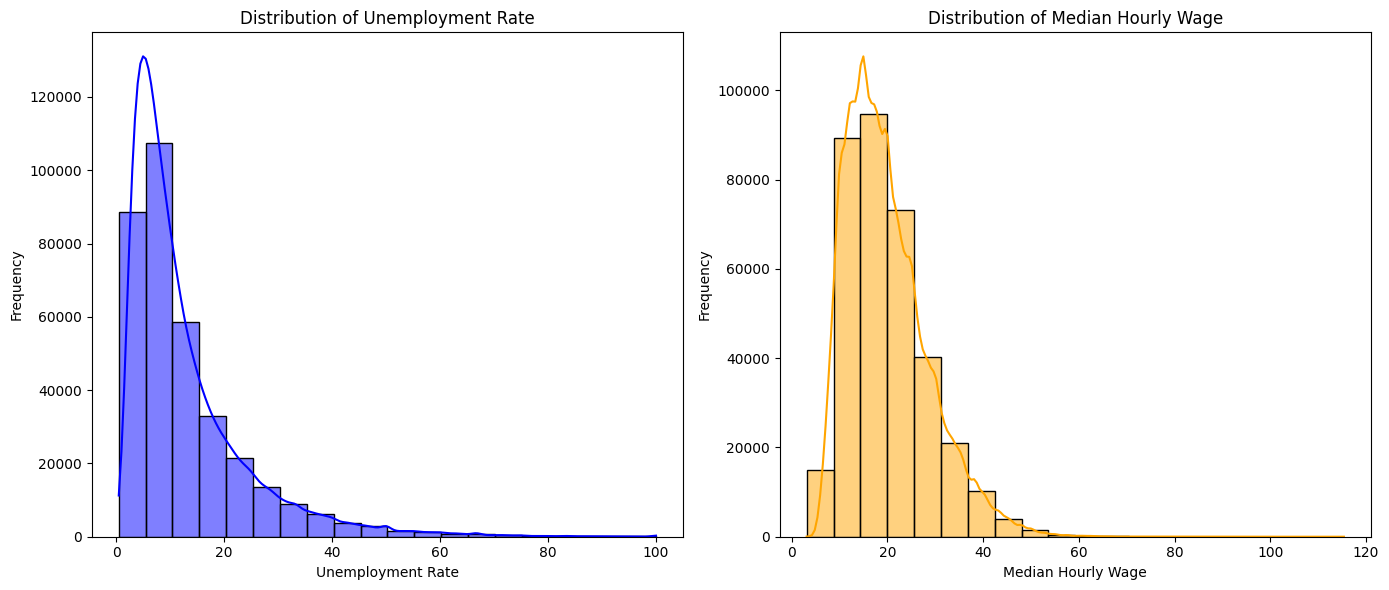

In [31]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the unemployment rate distribution on the first subplot
sns.histplot(interpolated_data['value_unemployment'], kde=True, bins=20, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Unemployment Rate')
axes[0].set_xlabel('Unemployment Rate')
axes[0].set_ylabel('Frequency')

# Plot the average hourly wage distribution on the second subplot
sns.histplot(interpolated_data['value_wage'], kde=True, bins=20, color='orange', ax=axes[1])
axes[1].set_title('Distribution of Median Hourly Wage')
axes[1].set_xlabel('Median Hourly Wage')
axes[1].set_ylabel('Frequency')

# Adjust layout to ensure there is no overlap between subplots
plt.tight_layout()
plt.show()


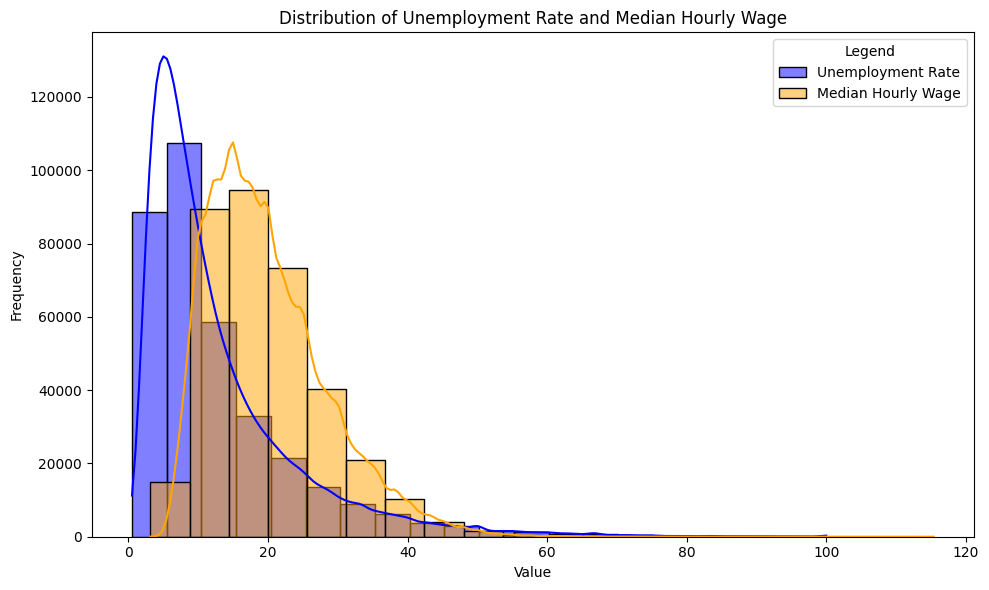

In [32]:
# Plot distributions of unemployment rate and wages on the same plot
plt.figure(figsize=(10, 6))

# Plot unemployment rate distribution
sns.histplot(interpolated_data['value_unemployment'], kde=True, bins=20, color='blue', label='Unemployment Rate')

# Plot average hourly wage distribution
sns.histplot(interpolated_data['value_wage'], kde=True, bins=20, color='orange', label='Median Hourly Wage')

# Add titles, labels, and legend
plt.title('Distribution of Unemployment Rate and Median Hourly Wage')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(title='Legend')  # Add a legend with a title

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# Stationarity

### ADF - Unemployment 

In [33]:
# Perform ADF test on 'value' column to check for stationarity
adf_test = adfuller(interpolated_data['value_unemployment'])
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing may be required.")


ADF Test Results:
ADF Statistic: -47.08360707113804
p-value: 0.0
The data is stationary.


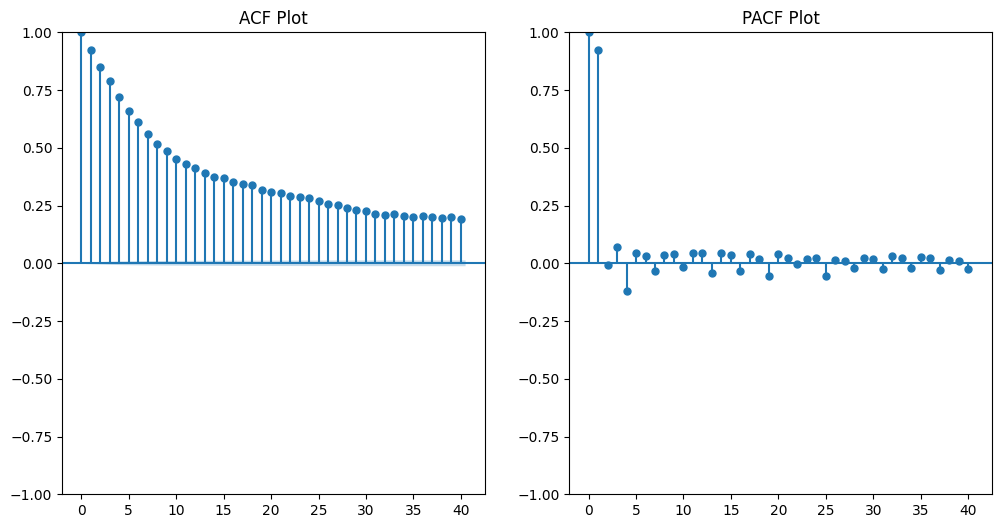

In [34]:
# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(interpolated_data['value_diff'].dropna() if 'value_diff' in interpolated_data else interpolated_data['value_unemployment'], 
         ax=plt.gca(), lags=40)
plt.title("ACF Plot")
plt.subplot(122)
plot_pacf(interpolated_data['value_diff'].dropna() if 'value_diff' in interpolated_data else interpolated_data['value_unemployment'], 
          ax=plt.gca(), lags=40)
plt.title("PACF Plot")
plt.show()

### ADF - Wage

In [35]:
# Perform ADF test on 'value' column to check for stationarity
adf_test = adfuller(interpolated_data['value_wage'])
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing may be required.")


ADF Test Results:
ADF Statistic: -18.770753258319225
p-value: 2.025232465551619e-30
The data is stationary.


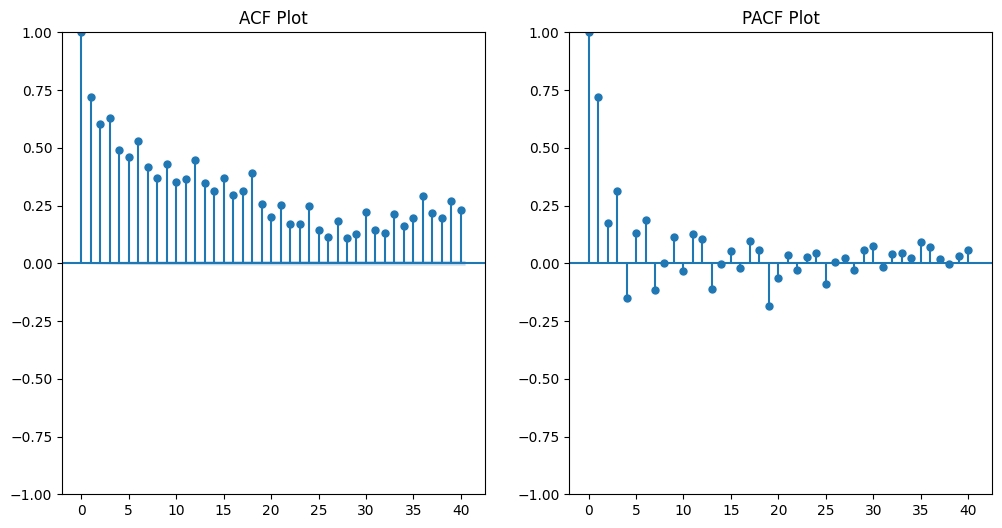

In [36]:
# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(interpolated_data['value_diff'].dropna() if 'value_diff' in interpolated_data else interpolated_data['value_wage'], 
         ax=plt.gca(), lags=40)
plt.title("ACF Plot")
plt.subplot(122)
plot_pacf(interpolated_data['value_diff'].dropna() if 'value_diff' in interpolated_data else interpolated_data['value_wage'], 
          ax=plt.gca(), lags=40)
plt.title("PACF Plot")
plt.show()

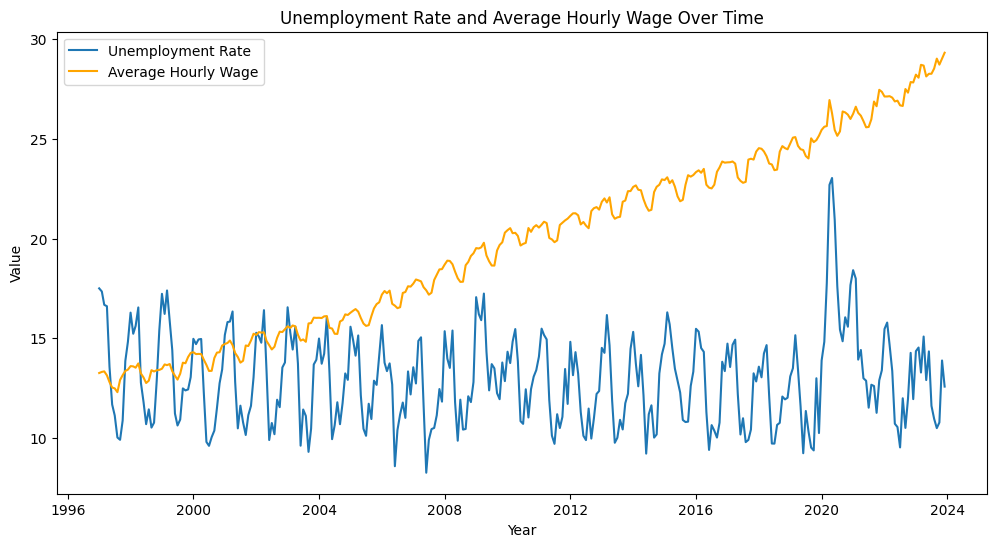

In [37]:
# Group data by reference date to create a time series of unemployment rate and average hourly wage
time_series_df = interpolated_data.groupby(['ref_date']).agg({
    'value_unemployment': 'mean',
    'value_wage': 'mean'
}).reset_index()

# Plot unemployment rate and wages over time
plt.figure(figsize=(12, 6))
plt.plot(time_series_df['ref_date'], time_series_df['value_unemployment'], label='Unemployment Rate')
plt.plot(time_series_df['ref_date'], time_series_df['value_wage'], label='Average Hourly Wage', color='orange')
plt.title('Unemployment Rate and Average Hourly Wage Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()